GORG CDS sequences used for this analysis were generated by Prokka during SCGC's standard SAG assembly and annotation pipeline.  

Default prokka parameters were used to call genes.  

All CDS from all GORG SAGs were then combined into one fasta file and clustered using mmseqs2 as follows:

<!---
pbs sub found at:
/mnt/scgc/scgc_nfs/lab/julia/pbs_subs/190212_mmseq_gorg_m80.sh
-->

```
cd /mnt/scgc/simon/simonsproject/gorg-clustering

name=gorg_sag_orfs
qual=80minid_m80
threads=50

faa=data/${name}.faa
db=analyses/${name}.db
db_clustered=analyses/${name}_${qual}.db_clustered
rep_seqs=analyses/${name}_${qual}.reps
out_fasta=analyses/${name}_${qual}.faa
out_tsv=analyses/${name}_${qual}.tsv
tmp_dir=data/tmp2/

mkdir $tmp_dir

mmseqs createdb $faa $db
mmseqs linclust --threads $threads -v 1 --min-seq-id 0.6 --kmer-per-seq 80 $db $db_clustered $tmp_dir
mmseqs result2repseq $db $db_clustered $rep_seqs  --threads $threads
mmseqs result2flat $db $db $rep_seqs $out_fasta --use-fasta-header
mmseqs createtsv $db $db $db_clustered $out_tsv --threads $threads -v 1
```  

Functions were assigned for each GORG cluster as follows:

*for each cluster, choose a random representative sequence within the group, and then pull out the annotation for that sequence from the prokka .gff file for the SAG from which it came.  snakemake script can be found in ```./scripts/190228_gorg_extract_functions.snakemake```*

Output table: ```"/mnt/scgc/simon/simonsproject/gorg-clustering/analyses/snakemake_cluster_tbl_rand_orf.tsv"```

In [30]:
%matplotlib inline


import pandas as pd
import os
import os.path as op
from collections import Counter
import math

import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt

import sklearn.metrics

def fit(df, x, y):
    
    def _check_fit(p, x, y):
        predicted = [p(i) for i in x]
        observed = y
        residuals = [x-y for x, y in zip(predicted, observed)]
        r2 = sklearn.metrics.r2_score(observed, predicted)
        stdev = np.std(residuals)
        return r2, stdev

    x = [float(i) for i in df[x].values]
    y = [float(i) for i in df[y].values]

    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    r2_order1, sd_order1 = _check_fit(p, x, y)
    return p, r2_order1, sd_order1

sns.set_style('white')

wd = "/mnt/scgc/simon/simonsproject/gorg-clustering/"
os.chdir(wd)

In [5]:
rand_orf_names = ['cluster','total_members','rand_orf','eC_number','product','Name']
df = pd.read_csv("analyses/snakemake_cluster_tbl_rand_orf.tsv", sep="\t",names=rand_orf_names)

In [20]:
# identify clusters characterized as "hypothetical protein"
df['hypothetical?'] = ['Hypothetical' if 'hypothetical protein' in l else "Not hypothetical" for l in df['product']]

# identify singleton clusters
df['single'] = ['Singletons' if i == 1 else 'Small_Clust' if i < 10 else 'Clusters' for i in df['total_members']]

# identify annotated sequences based on whether or not gene name assigned
df['annotated'] = ['not annotated' if type(i) == float else 'annotated' for i in df['Name']]

In [21]:
# incorporate protein sequence lengths into table

# below file created by script: scripts/190208_prot_sizes.py
aa_sizes_file = "analyses/gorg_sag_orfs_sizes.csv"
sizes = []
orfs = []

with open(aa_sizes_file) as ih:
    for count, l in enumerate(ih):
        size = int(l.strip().split(",")[-1])
        orf = l.split(" ")[0]
        sizes.append(size)
        orfs.append(orf)
        
aa_sizes = pd.DataFrame(data={'orf':orfs, "size":sizes})


# original cluster file from mmseqs2
tsv_file = 'analyses/gorg_sag_orfs_80minid_m80.tsv'
cdf = pd.read_csv(tsv_file, sep="\t", names = ['c1','c2'])
cdf['sag'] = [i.split(".")[0].split("_")[0] for i in cdf['c2']]
cdf.rename(columns={'c1':'cluster','c2':'orf'}, inplace=True)

csdf = cdf.merge(aa_sizes, on='orf', how='left')

csdf['size1'] = [int(i) for i in csdf['size']]

clust_sizes = csdf.groupby('cluster')['size1'].mean().reset_index().rename(columns={"size1":'average_size'})
clust_stdev = csdf.groupby('cluster')['size1'].std().reset_index().rename(columns={"size1":'stdev_size'})

adf = df.merge(clust_sizes, on='cluster', how='left').merge(clust_stdev, on='cluster', how='left')

In [22]:
adf['log_avg_size'] = [math.log(i, 10) for i in adf['average_size']]

In [23]:
adf.head()

,cluster,total_members,rand_orf,eC_number,product,Name,hypothetical?,single,annotated,average_size,stdev_size,log_avg_size
0,AG-470-O10_00608,35,AH-326-P14_00216,2.4.1.-,Rhamnosyltransferase WbbL,wbbL,Not hypothetical,Clusters,annotated,297.485714,8.406480,2.473466
1,AG-893-N16_00541,11,AG-893-I22_00083,NaN,hypothetical protein,NaN,Hypothetical,Clusters,not annotated,311.000000,0.000000,2.492760
2,AH-321-G20_00914,1,AH-321-G20_00914,NaN,hypothetical protein,NaN,Hypothetical,Singletons,not annotated,308.000000,NaN,2.488551
3,AG-447-L15_00133,34,AG-333-O07_00325,NaN,tRNA-modifying protein YgfZ,ygfZ,Not hypothetical,Clusters,annotated,276.264706,2.502227,2.441325
4,AG-896-G08_00719,3,AG-896-G08_00719,2.5.1.3,Thiamine-phosphate synthase,thiE,Not hypothetical,Small_Clust,annotated,71.000000,0.000000,1.851258


In [24]:
seq_counts = adf.groupby('single')['total_members'].sum()
clust_counts = adf.groupby('single')['total_members'].count()

In [25]:
print("There are", round(adf['total_members'].sum() / 1000000, 1), "million ORFs from GORG belonging to", round(len(adf) / 1000000, 1), "million clusters.")
print("Of these clusters", round((clust_counts['Singletons'] / len(adf)) * 100, 1), "% consist of only one sequence.")
print("However, the majority,", round((seq_counts['Clusters'] / adf['total_members'].sum()) * 100, 1),"%, of sequences belong to clusters containing more than one sequence.")

There are 8.2 million ORFs from GORG belonging to 1.1 million clusters.
Of these clusters 61.3 % consist of only one sequence.
However, the majority, 78.6 %, of sequences belong to clusters containing more than one sequence.


/mnt/scgc_nfs/opt/common/anaconda3/4.0.0/lib/python3.5/site-packages/seaborn-0.7.1-py3.5.egg/seaborn/categorical.py:637: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data[hue_mask])
/mnt/scgc_nfs/opt/common/anaconda3/4.0.0/lib/python3.5/site-packages/seaborn-0.7.1-py3.5.egg/seaborn/categorical.py:932: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data[hue_mask])


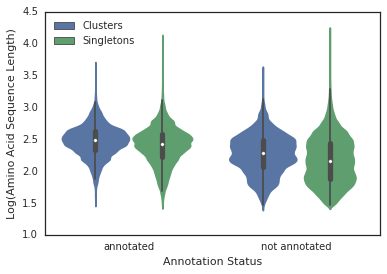

In [26]:
sns.violinplot('annotated',
            'log_avg_size',
            hue = 'single', 
            data = adf[(adf['total_members'] > 10)|(adf['total_members'] == 1)]).set(xlabel = "Annotation Status",
                           ylabel = "Log(Amino Acid Sequence Length)")
plt.legend(loc=2)
#plt.savefig("analyses/plots/gorg-clustering_single_vs_multi_size_violinplots.png", dpi = 300)
#plt.savefig("analyses/plots/gorg-clustering_single_vs_multi_size_violinplots.svg")

In [28]:
# count singles and clusters

single_cluster_count = df.groupby('single')['cluster'].count().reset_index().rename(columns={'cluster':'total_clusters'})
single_cluster_count

,single,total_clusters
0,Clusters,96397
1,Singletons,654009
2,Small_Clust,316045


Count occurence of different EC values within singletons versus clustered sequences.

In [42]:
colors = ["#cc535c",
"#4ab1a9",
"#bd5db0",
"#76a44a",
"#7179cb",
"#c3843e",
"#cc5143",
"#000000"]
cdict = dict(zip([str(i) for i in np.arange(1,8)],colors))
cdict['None'] = "#000000"

ecdict = {'1':'Oxidoreductase',
         '2':'Transferase',
         '3':'Hydrolase',
         '4': 'Lyase',
         '5': 'Isomerase',
         '6': 'Ligase',
         '7': 'Translocase'}

In [43]:
# summarize counts

ec_count = df.fillna('None').groupby(['single','eC_number'])['cluster'].count().reset_index()
ec_count['proportion'] = [i['cluster'] / single_cluster_count[single_cluster_count['single'] == i['single']]['total_clusters'].values[0] for l, i in ec_count.iterrows()]

for i in range(1,5):
    col = "ec{}".format(i)
    ec_count[col] = [".".join(j.split(".")[0:i]) if j != "None" else "None" for j in ec_count['eC_number'] ]

ec3 = ec_count.groupby(['single','ec3'])['proportion'].sum().reset_index().pivot(index='ec3',columns='single',values='proportion').reset_index().fillna(0)

ec3['level1'] = [i.split(".")[0] for i in ec3['ec3']]
ec3['level1_color'] = ['#000000' if i == "None" else cdict[i] for i in ec3['level1']]


In [44]:
# fit linear regression

r2 = round(fit(ec3, 'Clusters','Singletons')[1],3)
r2_statement = "r2 = {}".format(r2)

ec3fit = fit(ec3[ec3['ec3'] != 'None'], 'Clusters','Singletons')
ec_eq = 'y = {}x + {}'.format(round(ec3fit[0][1],3), round(ec3fit[0][0], 5))
ec_eq

'y = 0.649x + -0.0001'

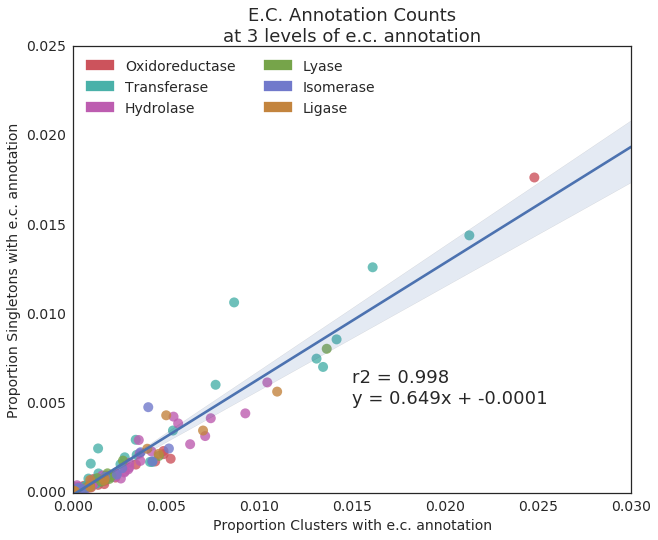

In [45]:
from matplotlib.patches import Patch

plt.figure(figsize=(10,8))

p = sns.regplot('Clusters',
            'Singletons',
            data=ec3[ec3['ec3'] != 'None'], 
            fit_reg = True, 
            scatter_kws={"s":100, 
                         'facecolors':ec3['level1_color']})

p.set_xlabel('Proportion Clusters with e.c. annotation', fontsize=14) 
p.set_ylabel('Proportion Singletons with e.c. annotation', fontsize=14)
p.set_title('E.C. Annotation Counts\nat 3 levels of e.c. annotation', fontsize=18)
p.tick_params(labelsize=14)

plt.xlim(0,)
plt.ylim(0,)

legend_elements = [Patch(facecolor=cdict[i], edgecolor=cdict[i], label=ecdict[i]) for i in ec3['level1'].unique() if i != 'None']
plt.legend(handles=legend_elements, loc=2,
fancybox=False, shadow=False, frameon=False, ncol=2, fontsize=14)

plt.text(0.015, 0.005, r2_statement + "\n" + ec_eq, fontsize = 18)
